### 0. 패키지 로딩하기

In [1]:
from PIL        import Image
from tensorflow import keras

import os
import cv2
import copy
import urllib3
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

urllib3.disable_warnings()

In [2]:
# GPU 상태 확인하기
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1. CAM, Grad-CAM용 모델 준비하기 (1) 데이터셋 준비하기

* CAM(Class Activation Map)은 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)와 소프트맥스 레이어(Softmax Layer)가 붙은 형태로 구성되어야 한다는 제약이 있다.
* 반면에 Grad-CAM은 이러한 제약이 없다.
* 이번 시간에는 두 가지를 모두 구현해 본다.
* 우선 CAM을 위한 모델을 먼저 구성해 기본적인 CAM을 추출해보고, 이 모델에서 Grad-CAM을 활용해 다시 시각화 결과물을 추출하겠다.
* Grad-CAM은 모델의 구조에 제약이 없기 때문에 CAM에만 모델을 맞춰도 충분하다.
* CAM은 클래스에 대한 활성화 정도를 나타낸 지도이다.
* 따라서 기본적으로 우리의 모델은 분류(classfication)를 수행하는 모델이어야 한다.
* 하지만 우리의 최종 목표는 이미지 내에서 클래스가 활성화 된 위치를 확인하고 이를 정답과 비교하는 것이므로 위치 정보가 기록된 데이터가 함께 있어야한다.
* Tensorflow Datasets의 카탈로그에서 이러한 데이터를 확인할 수 있다.
* 여기서는 Cars196 데이터셋을 사용한다.
* 이는 196종의 자동차 종류를 사진으로 판별하는 분류 문제 데이터셋으로, 라벨의 위치정보인 바운딩 박스(bounding box) 정보를 포함하고 있다.

* cars196 데이터셋은 8,144장의 학습용 데이터셋과 8,041장의 평가용 데이터셋으로 구성되어있다.
* tfds.load()를 활용해서 데이터셋을 다운로드 해준다.
* (주의) 아래 데이터셋은 총 사이즈 1.8GB에 이르는 대용량 데이터셋이다. 최초로 load()를 호출하는 경우 다운로드에 1시간 가량 소요될 수 있다.

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    "cars196",
    split         = ["train", "test"],
    shuffle_files = True,
    with_info     = True
)

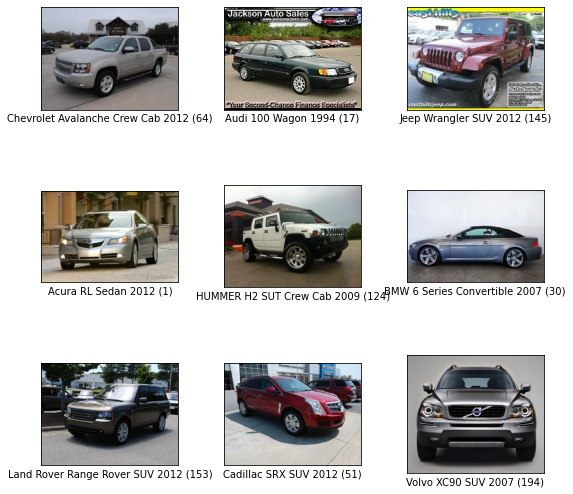

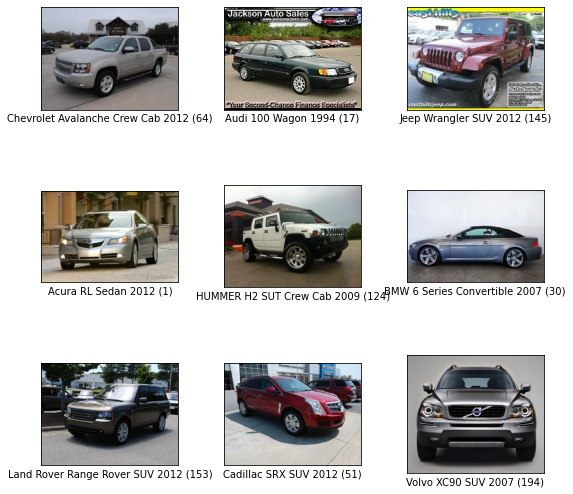

In [4]:
# tfds.show_examples()를 통해서 각 이미지의 클래스와 그 인덱스(index)를 확인할 수 있다.
tfds.show_examples(ds_train, ds_info)

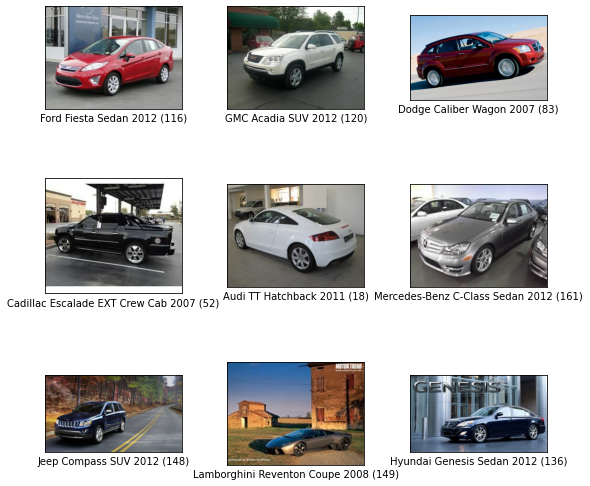

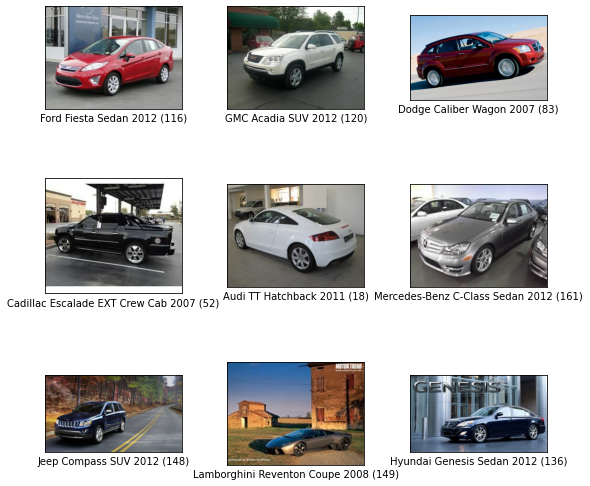

In [5]:
# 학습용 데이터셋 뿐만 아니라 평가용 데이터셋도 눈으로 확인해볼 수 있다.
tfds.show_examples(ds_test, ds_info)

### 2. CAM, Grad-CAM용 모델 준비하기 (2) 물체의 위치정보

* 원본 이미지 위에 물체의 위치정보는 어떻게 시각화 하여 표시할 수 있을까?
* 데이터셋의 메타 정보인 df_info를 조회해 features가 어떻게 구성되어 있는지 확인해 보자.

In [6]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

* 먼저 image와 label은 입력 이미지와 이미지에 해당하는 정답 클래스의 인덱스이다.
* 몇 번 본적이 있는가?
* 그런데 조금 새로운 키(key)가 있다.
* bbox는 무엇일까?
* bbox(바운딩 박스)는 물체의 위치를 사각형 영역으로 표기하는 방법이다.
* 위에서 확인한 바로는 BBoxFeature이라는 타입으로 정의되어 있다.

#### 2_1. 바운딩 박스를 표시하는 방법들

* 바운딩 박스를 라벨링하는 방법은 아주 다양하다.
* 그 중 주로 사용되는 방법은 "xywh" 또는 "minmax"로 표기하는 방법이다.
* 1. "xywh"는 바운딩박스 중심점을 x, y로 표기하고, 사각형의 너비 w와 높이 h를 표기하는 방법이다.
* 1_1. (예) (x_center, y_center, width, height)
* 1_2. x, y가 중심점이 아니라 좌측 상단의 점을 가리킬 수도 있다.
* 2. "minmax"는 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법이다.
* 2_1. (예) (x_min, x_max, y_min, y_max)
* 2_2. 좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는 것이 일반적이다.
* 위 두가지 뿐만 아니라 이미지의 상하좌우 끝단으로부터 거리로 표현하는 방법, 좌우측의 x값과 상하측의 y값 네 개로 표시하는 방법(LRTB), 네 점의 x, y 좌표 값을 모두 표시하는 방법(QUAD) 등 여러 가지 방법이 있다.
* 따라서 새로운 데이터셋을 접하거나 라이브러리를 활용할 때는 간단한 바운딩 박스 정보라도 한 번 더 표기법을 확인하고 넘어가는 것이 좋다.
* (질문) 그럼 주어진 데이터셋에서 BBoxFeature 타입으로 표기된 bbox 필드는 어떤 방식으로 바운딩박스를 라벨링하고 있는지?
* (대답) 해당 bounding box는 minmax를 의미한다. tensorflow datasets의 경우 height를 첫번째 axis로 삼고있어 [minY, minX, maxY, maxX]를 의미하게 된다.

### 3. CAM, Grad-CAM용 모델 준비하기 (3) CAM을 위한 모델 만들기

* 이제 본격적으로 CAM을 얻어내기 위한 모델을 만든다.
* 이번에는 미리 이미지넷(imagenet) 데이터에 훈련된 resnet50을 기반으로 활용하고, 이후 pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델을 만든다.
* 참고로, 소프트맥스 레이어는 소프트맥스 함수를 활성화 함수로 사용하는 fully connected 레이어이다.

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model  = keras.applications.resnet.ResNet50(
    include_top = False,         # Imagenet 분류기에서 fully connected layer 제거하기
    weights     = "imagenet",
    input_shape = (224, 224, 3),
    pooling     = "avg"          # GAP(Global Average Pooling)를 적용시키기
)
x         = base_model.output
preds     = keras.layers.Dense(num_classes, activation = "softmax")(x)
cam_model = keras.Model(inputs = base_model.input, outputs = preds)

* CAM 모델은 지금껏 했던 분류 문제를 위한 모델과 크게 다른 점이 없다.
* 다만 마지막 fully connected layer 대신 GAP(Global Average Pooling)을 사용해주어야 한다.
* 지금의 경우 keras.application의 ResNet50의 매개변수 pooling에 "avg"를 매개변수로 전달함으로써 쉽게 GAP 연산을 붙일 수 있다.

In [8]:
# 위에서 만든 모델 확인하기.
cam_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

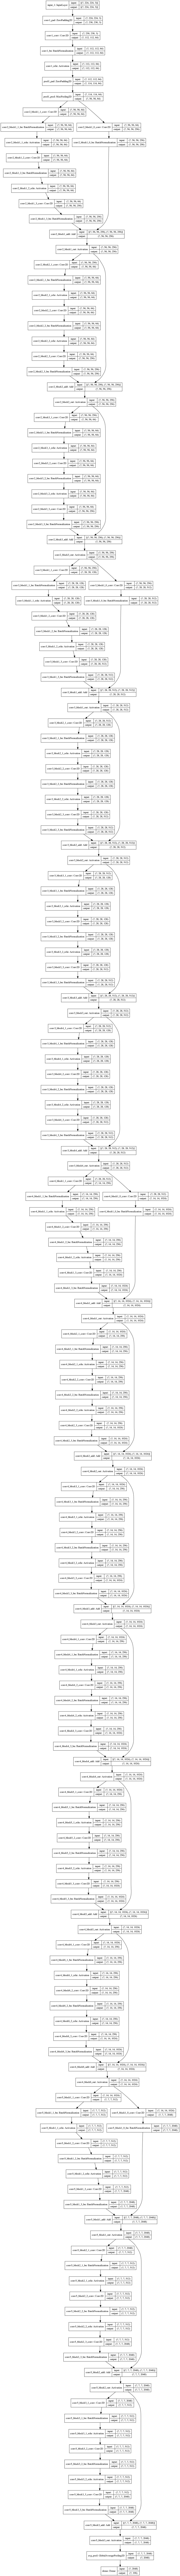

In [9]:
# (이전 프로젝트에서 유용하게 썼던 코드인) 모델 구조를 시각화 해보기
tf.keras.utils.plot_model(cam_model, to_file = "CAM.png", show_shapes = True)

* 이번 노드에서는 별로 유용하지 않을 듯 하다.
* (질문) CAM은 특성 맵(feature map)을 사용해 만든다. 위 레이어들 중 우리가 사용하는 특성 맵은 어떤 레이어의 출력값일까?
* (대답) conv5_block3_out의 output이 feature map이 된다. 따라서 이 feature map에 Global average pooling을 하여 feature의 크기를 줄이고, 줄어든 feature 전체에 Dense layer를 붙여 classification을 수행하게 된다.

### 4. CAM, Grad-CAM용 모델 준비하기 (4) CAM 모델 학습하기

#### 4_2. 학습을 위한 데이터 만들기

* 학습을 위한 과정은 이전과 비슷하다.
* 학습 데이터와 검증 데이터에 normalizing과 resizing을 포함한 간단한 전처리를 normalize_and_resize_img()에서 수행하며, 이를 포함하여 apply_normalize_on_dataset()에서 배치를 구성한다.
* input에 이전과 다르게 bbox 정보가 포함되어있지만, 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 normalize_and_resize_img과정에서 제외해 줬다.
* CAM 모델은 object detection이나 segmentation에도 활용될 수 있지만, bounding box같은 직접적인 라벨을 사용하지 않고 weakly supervised learning(약지도학습)을 통해 물체 영역을 간접적으로 학습시키는 방식이기 때문이다.

In [9]:
def normalize_and_resize_img(input):
    """Normalizes images : "uint8" -> "float32"."""
    image          = tf.image.resize(input["image"], [224, 224])
    input["image"] = tf.cast(image, tf.float32) / 255.
    
    return input["image"], input["label"]

In [10]:
def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls = 2
    )
    
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [12]:
# 데이터셋에 전처리와 배치처리를 적용한다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm  = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인하기
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


#### 4_2. 모델 컴파일하고 학습시키기
* 학습에는 20 ~ 30분 가량 소요된다. (epochs = 15 기준)

In [13]:
tf.random.set_seed(2021)

In [14]:
# model compile
cam_model.compile(
    loss      = "sparse_categorical_crossentropy",
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics   = ["accuracy"]
)

In [15]:
# model fit
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch     = int(ds_info.splits["train"].num_examples / 16),
    validation_steps    = int(ds_info.splits["test"].num_examples  / 16),
    epochs              = 15,
    validation_data     = ds_test_norm,
    verbose             = 1,
    use_multiprocessing = True
)

Epoch 1/15
  2/509 [..............................] - ETA: 41s - loss: 5.9889 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0583s vs `on_train_batch_end` time: 0.1031s). Check your callbacks.


509/509 [==============================] - 99s 194ms/step - loss: 4.1586 - accuracy: 0.1703 - val_loss: 5.2862 - val_accuracy: 0.0168
Epoch 2/15
509/509 [==============================] - 83s 163ms/step - loss: 1.6465 - accuracy: 0.6358 - val_loss: 2.0629 - val_accuracy: 0.4744
Epoch 3/15
509/509 [==============================] - 83s 163ms/step - loss: 0.5664 - accuracy: 0.9032 - val_loss: 1.3539 - val_accuracy: 0.6527
Epoch 4/15
509/509 [==============================] - 83s 164ms/step - loss: 0.1893 - accuracy: 0.9808 - val_loss: 1.0813 - val_accuracy: 0.7094
Epoch 5/15
509/509 [==============================] - 83s 163ms/step - loss: 0.0675 - accuracy: 0.9974 - val_loss: 1.0632 - val_accuracy: 0.7151
Epoch 6/15
509/509 [==============================] - 83s 164ms/step - loss: 0.0416 - accuracy: 0.9973 - val_loss: 1.0202 - val_accuracy: 0.7287
Epoch 7/15
509/509 [==============================] - 83s 164ms/step - loss: 0.0267 - accuracy: 0.9985 - val_loss: 0.9875 - val_accuracy: 0.7

In [16]:
# 학습시킨 가중치 저장하기
cam_model_path = os.getenv("HOME") + "/aiffel/class_activation_map/cam_model.h5"
cam_model.save(cam_model_path)

In [17]:
# 참고 : 저장된 모델은 이후 아래와 같이 로드해서 활용할 수 있다.
# model = tf.keras.models.load_model(model_path)

### 5. CAM

* 이제 학습한 모델을 활용하여 CAM을 생성해보겠다.
* 메모리 부족으로 인해 실습에 문제가 발생할 경우, 커널을 재시작하면 된다.

In [11]:
# # 커널을 재시작 할 경우 이후 실습을 위해, 이전 스텝의 코드를 한꺼번에 실행하기 위해 한 셀에 코드를 모왔다.
# # 0. 패키지 로딩하기
# from PIL        import Image
# from tensorflow import keras

# import os
# import cv2
# import copy
# import urllib3
# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import tensorflow_datasets as tfds

# urllib3.disable_warnings()

# # 1. 데이터 불러오기
# (ds_train, ds_test), ds_info = tfds.load(
#     "cars196",
#     split         = ["train", "test"],
#     shuffle_files = True,
#     with_info     = True
# )

# # 필요한 함수 정의하기
# def normalize_and_resize_img(input):
#     """Normalizes images : "uint8" -> "float32"."""
#     image          = tf.image.resize(input["image"], [224, 224])
#     input["image"] = tf.cast(image, tf.float32) / 255.
    
#     return input["image"], input["label"]

# def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16):
#     ds = ds.map(
#         normalize_and_resize_img, 
#         num_parallel_calls = 2
#     )
    
#     ds = ds.batch(batch_size)
#     if not is_test:
#         ds = ds.repeat()
#         ds = ds.shuffle(200)
    
#     ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
#     return ds

* 학습된 모델에서 CAM을 생성해 본다.
* CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, get_one()함수로 데이터셋에서 한 장씩 뽑을 수 있도록 했다.

In [12]:
def get_one(ds):
    ds          = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox        = sample_data[0]["bbox"]
    image       = sample_data[0]["image"]
    label       = sample_data[0]["label"]
    
    return sample_data[0]

122


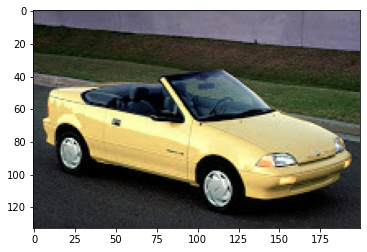

In [13]:
item = get_one(ds_test)

print(item["label"])
plt.imshow(item["image"])

* 데이터는 준비되었다.
* 커널을 재시작 했을 경우 CAM을 생성하기 위해 위에서 학습한 모델을 불러오자. 

In [14]:
# cam_model_path = os.getenv("HOME") + "/aiffel/class_activation_map/cam_model.h5"
# cam_model      = tf.keras.models.load_model(cam_model_path)

* CAM을 생성하기 위해서는
* 1. 특성 맵
* 2. 클래스 별 확률을 얻기 위한 소프트맥스 레이어의 가중치
* 3. 원하는 클래스의 출력값
* 이 필요하다.
* 또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화 해야한다.
* 이를 고려해서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 한다.
* generate_cam()을 구현하기 위해 아래에서는 conv_ouputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feed forward를 거친 후 CAM을 계산하도록 구현했다.
* 마지막에는 입력 이미지의 크기에 맞춰 CAM을 resize 했다.

In [15]:
def generate_cam(model, item):
    item   = copy.deepcopy(item)
    width  = item["image"].shape[1]
    height = item["image"].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의한다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있다.
    cam_model                 = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs  = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]   # 마지막 모델의 weight activation을 가져온다.
    
    cam_image = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
    
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산한다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image)                      # activation score를 normalize한다.
    cam_image  = cam_image.numpy()
    cam_image  = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize한다.
    
    return cam_image

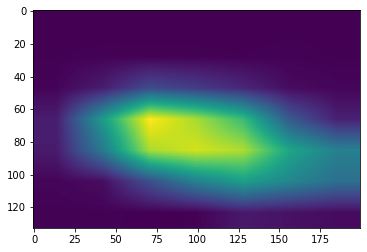

In [16]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

* 위에서 그려진 CAM 이미지를 원본 이미지와 합쳐보자.

In [17]:
def visualize_cam_on_image(src1, src2, alpha = 0.5):
    beta         = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    
    return merged_image

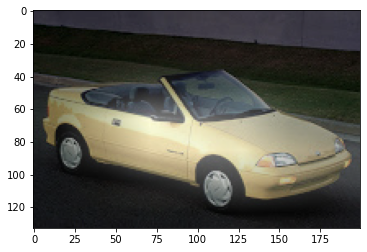

In [18]:
origin_image       = item["image"].astype(np.uint8)
cam_image_3channel = np.stack([cam_image * 255] * 3, axis = -1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

* get_one 함수를 정의한 다음부터 코드를 몇 번 반복하다보면 주로 차량의 전면 엠블럼이 있는 부분이 강조되는 경향을 파악할 수 있다.
* 이것은 사람이 차종을 식별할 때 유의해서 보는 부분과 일맥상통하다는 것을 확인할 수 있다.

### 6. Grad-CAM

* 이번에는 Grad-CAM을 이용해서 CAM을 얻어보도록 한다.
* 적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성 상 위에서 만들었던 모델을 다시 활용해도 괜찮기 때문에 관찰 대상 모델은 cam_model을 그대로 활용한다.
* 우선 새로운 이미지를 뽑아보자.

122


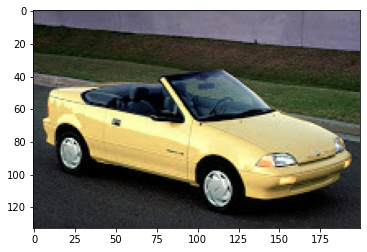

In [19]:
item = get_one(ds_test)

print(item["label"])
plt.imshow(item["image"])

* 이번에는 Grad-CAM을 이용해서 CAM을 만들어 본다.
* grad_cam은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구한다.
* 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합 해주어 cam_image를 얻게 된다.
* 위에서 본 CAM 함수와 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 한다.
* 아래 generate_grad_cam()에서는 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용한다.

In [20]:
def generate_grad_cam(model, activation_layer, item):
    item   = copy.deepcopy(item)
    width  = item["image"].shape[1]
    height = item["image"].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의한다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가한다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용한다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss     = pred[:, class_idx]                  # 원하는 class(여기서는 정답으로 활용) 예측값을 얻는다.
        output   = conv_output[0]                      # 원하는 layer의 output을 얻는다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻는다.

    weights        = np.mean(grad_val, axis = (0, 1))  # gradient의 GAP으로 class별 weight를 구한다.
    grad_cam_image = np.zeros(dtype = np.float32, shape = conv_output.shape[0:2])
    
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻는다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image  = grad_cam_image.numpy()
    grad_cam_image  = cv2.resize(grad_cam_image, (width, height))
    
    return grad_cam_image

* 이제 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해보자.
* 레이어의 이름은 cam_model.summary()에서 찾을 수 있다.
* 아래 그림은 모든 _out으로 끝나는 레이어를 시각화했다.
* 위가 제일 마지막 층이고, 아래가 첫번째 out층이다.

In [21]:
cam_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

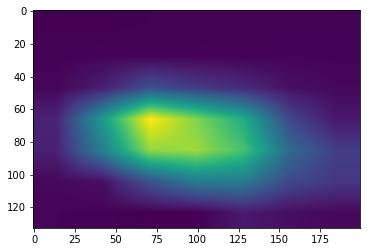

In [22]:
grad_cam_image = generate_grad_cam(cam_model, "conv5_block3_out", item)
plt.imshow(grad_cam_image)

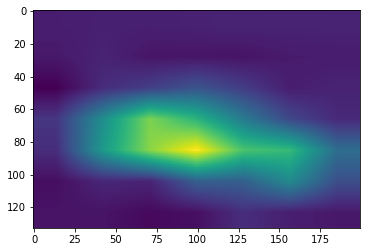

In [23]:
grad_cam_image = generate_grad_cam(cam_model, "conv5_block2_out", item)
plt.imshow(grad_cam_image)

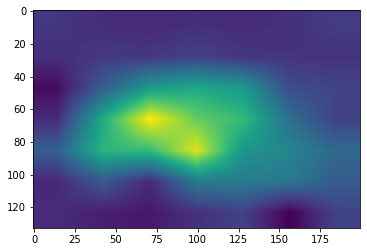

In [24]:
grad_cam_image = generate_grad_cam(cam_model, "conv5_block1_out", item)
plt.imshow(grad_cam_image)

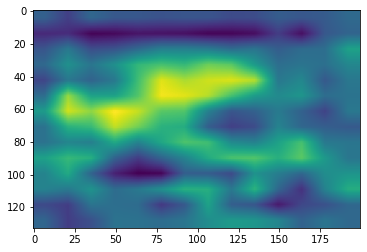

In [25]:
grad_cam_image = generate_grad_cam(cam_model, "conv4_block6_out", item)
plt.imshow(grad_cam_image)

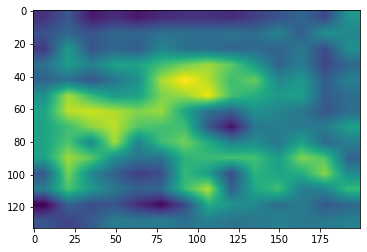

In [26]:
grad_cam_image = generate_grad_cam(cam_model, "conv4_block5_out", item)
plt.imshow(grad_cam_image)

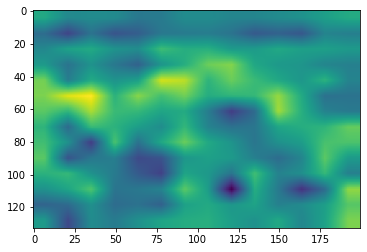

In [27]:
grad_cam_image = generate_grad_cam(cam_model, "conv4_block4_out", item)
plt.imshow(grad_cam_image)

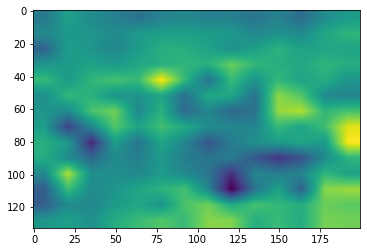

In [28]:
grad_cam_image = generate_grad_cam(cam_model, "conv4_block3_out", item)
plt.imshow(grad_cam_image)

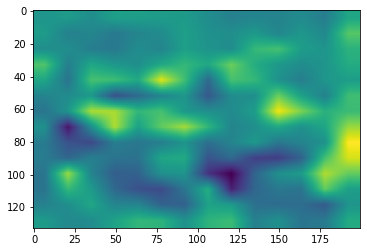

In [29]:
grad_cam_image = generate_grad_cam(cam_model, "conv4_block2_out", item)
plt.imshow(grad_cam_image)

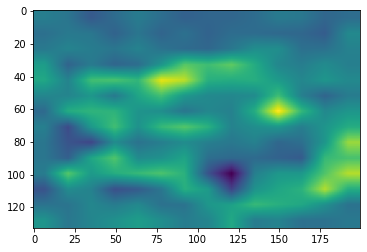

In [30]:
grad_cam_image = generate_grad_cam(cam_model, "conv4_block1_out", item)
plt.imshow(grad_cam_image)

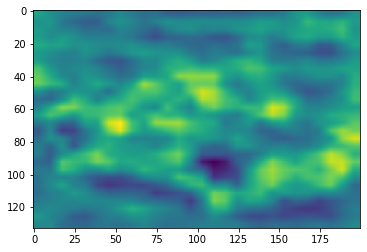

In [31]:
grad_cam_image = generate_grad_cam(cam_model, "conv3_block4_out", item)
plt.imshow(grad_cam_image)

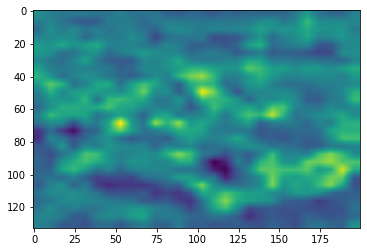

In [32]:
grad_cam_image = generate_grad_cam(cam_model, "conv3_block3_out", item)
plt.imshow(grad_cam_image)

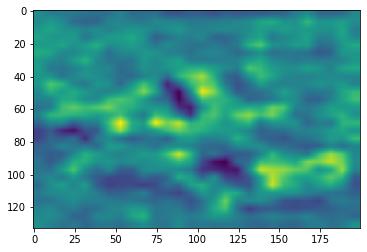

In [33]:
grad_cam_image = generate_grad_cam(cam_model, "conv3_block2_out", item)
plt.imshow(grad_cam_image)

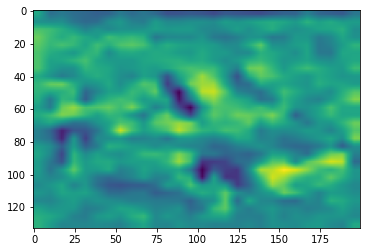

In [34]:
grad_cam_image = generate_grad_cam(cam_model, "conv3_block1_out", item)
plt.imshow(grad_cam_image)

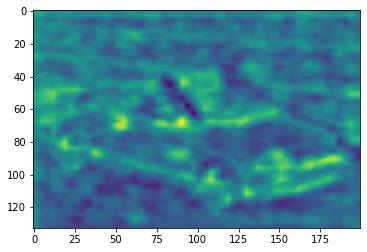

In [35]:
grad_cam_image = generate_grad_cam(cam_model, "conv2_block3_out", item)
plt.imshow(grad_cam_image)

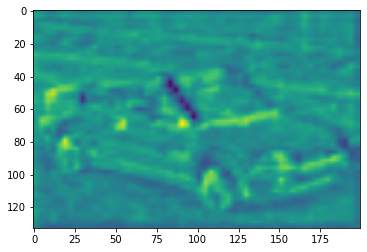

In [36]:
grad_cam_image = generate_grad_cam(cam_model, "conv2_block2_out", item)
plt.imshow(grad_cam_image)

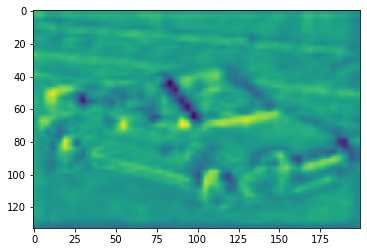

In [37]:
grad_cam_image = generate_grad_cam(cam_model, "conv2_block1_out", item)
plt.imshow(grad_cam_image)

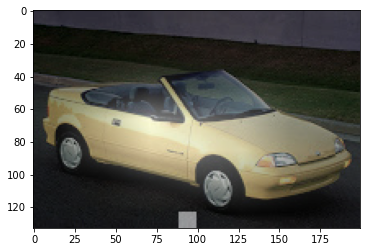

In [38]:
grad_cam_image          = generate_grad_cam(cam_model, "conv5_block3_out", item)
origin_image            = item["image"].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image * 255] * 3, axis = -1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

### 7. Detection with CAM

* CAM에서 물체의 위치를 찾는 detection을 해 보도록 하겠다.
* 다시 새로운 이미지를 뽑는다.

122


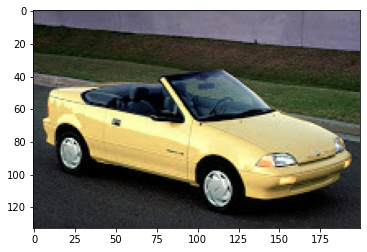

In [56]:
item = get_one(ds_test)

print(item["label"])
plt.imshow(item["image"])

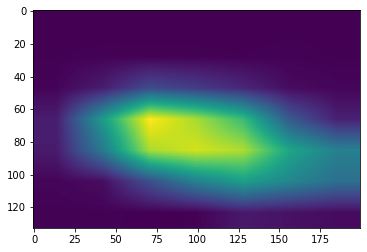

In [57]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

* 이전의 generate_cam을 활용해서 CAM 이미지를 뽑아보자.
* 아래 get_bbox() 함수는 바운딩 박스를 만들기 위해서 score_thresh를 받아 역치값 이하의 바운딩 박스는 없앤다.
* 그 다음 OpenCV의 findContours()와 minAreaRect()로 사각형을 찾는다.
* 이때 rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있다.
* boxPoints()로 이를 꼭지점으로 바꾸어 준다.
* 마지막에는 int 자료형으로 변환해 준다.

In [58]:
def get_bbox(cam_image, score_thresh = 0.05):
    low_indicies            = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image               = (cam_image * 255).astype(np.uint8)
    contours,_              = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt                     = contours[0]
    rotated_rect            = cv2.minAreaRect(cnt)
    rect                    = cv2.boxPoints(rotated_rect)
    rect                    = np.int0(rect)
    return rect

* cam_image를 통해 bbox를 얻고 이를 이미지 위에 시각화한 모습을 볼 수 있다.

In [59]:
image = copy.deepcopy(item["image"])
rect  = get_bbox(cam_image)
rect

array([[ -6, 117],
       [  4,  22],
       [207,  44],
       [196, 140]])

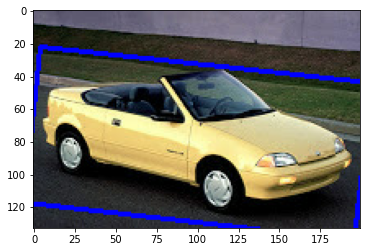

In [60]:
image = cv2.drawContours(image, [rect], 0, (0, 0, 255), 2) # 이미지, 박스 좌표, 선 색깔, 선 굵기
plt.imshow(image)

### 8. (CAM) Intersection Over Union

* 위에서 CAM과 Grad-CAM 두 가지 방법을 통해서 얻은 바운딩 박스가 있다.
* 그럼 정답 데이터인 바운딩 박스와 이를 비교 평가 할 때는 어떻게 할 수 있을까?
* IoU(Intersection over Union)는 두 개 영역의 합집합인 "union" 영역으로 교집합 영역인 "intersection" 영역의 넓이를 나누어준 값이다.
* 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지 상대적인 비율을 구할 수 있으므로 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 된다.

In [61]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어진다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:, 1].min() / float(image.shape[0]), #bounding box의 y_min
        rect[:, 0].min() / float(image.shape[1]), #bounding box의 x_min
        rect[:, 1].max() / float(image.shape[0]), #bounding box의 y_max
        rect[:, 0].max() / float(image.shape[1])  #bounding box의 x_max
    ]
    
    return bbox

In [62]:
# 위에서 구했던 rect를 minmax bbox 형태로 치환한다.
pred_bbox = rect_to_minmax(rect, item["image"])
pred_bbox

[0.16541353383458646, -0.03, 1.0526315789473684, 1.035]

In [63]:
# 데이터의 ground truth bbox를 확인한다.
item["bbox"]

array([0.24812031, 0.03      , 0.9398496 , 0.985     ], dtype=float32)

* 얼마나 유사한지를 IoU를 계산해서 확인한다.

In [64]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min = max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea  = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea  = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou       = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [65]:
get_iou(pred_bbox, item["bbox"])

0.6991326415264646

### 9. Detection with Grad-CAM

* Grad-CAM에서 물체의 위치를 찾는 detection을 해 보도록 하겠다.
* 다시 새로운 이미지를 뽑는다.

122


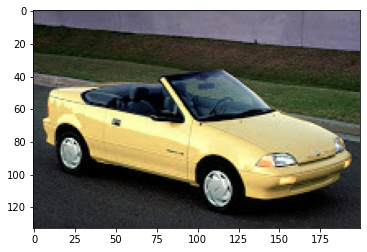

In [131]:
item = get_one(ds_test)

print(item["label"])
plt.imshow(item["image"])

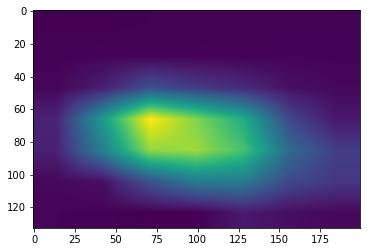

In [132]:
grad_cam_image = generate_grad_cam(cam_model, "conv5_block3_out", item)
plt.imshow(grad_cam_image)

In [133]:
image = copy.deepcopy(item["image"])
rect  = get_bbox(grad_cam_image)
rect

array([[ -5, 122],
       [  2,  25],
       [204,  41],
       [197, 137]])

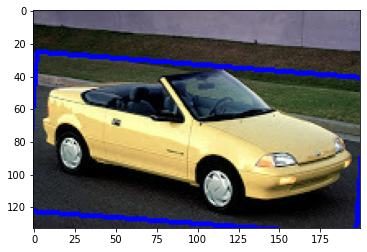

In [134]:
image = cv2.drawContours(image, [rect], 0, (0, 0, 255), 2) # 이미지, 박스 좌표, 선 색깔, 선 굵기
plt.imshow(image)

### 10. (Grad-CAM) Intersection Over Union

In [135]:
# 위에서 구했던 rect를 minmax bbox 형태로 치환한다.
pred_bbox = rect_to_minmax(rect, item["image"])
pred_bbox

[0.18796992481203006, -0.025, 1.0300751879699248, 1.02]

In [136]:
# 데이터의 ground truth bbox를 확인한다.
item["bbox"]

array([0.24812031, 0.03      , 0.9398496 , 0.985     ], dtype=float32)

* 얼마나 유사한지를 IoU를 계산해서 확인한다.

In [137]:
get_iou(pred_bbox, item["bbox"])

0.7506835189732639

### 회고록

In [ ]:
# 일단 정확하게 비교하기 위해서 122번째 데이터를 사용했다.
# CAM와 Grad-CAM를 시각화했을 경우 거의 차이가 안 보였다.
# bbox를 그리고 iou를 계산했을 경우 bbox에서도 차이가 안 보이는데 iou 수치는 0.699와 0.750로 Grad-CAM가 좀 더 높은 수치를 보였다.

# 추가로 구현은 노드를 안보고서는 혼자 구현을 못해서 노드를 보고 따라 쓰면서 코드를 이해하고 구현했다.